
# The Life Cycle Model: Theory vs Data

National registry data on income and wealth from Scandinavian countries (esp. Norway) have recently become available (with a lot of security) to some (lucky!) researchers.   These data offer a uniquely powerful tool for testing (and improving) our models of consumption and saving behavior over the life cycle.

This notebook is an example of how to construct a life cycle model with the HARK toolkit that makes predictions that can be compared to the raw data statistics=.

For example, some papers have tabulated information about the **growth rate** of assets at different ages over the life cycle. 

The default parameters of the HARK life cycle model have not been optmized to match features of the Norwegian data; a first step in a real "structural" estimation would be to use Norwegian calibrate the inputs to the model (like the profile of income, and the magnitude of income shocks, over the life cycle), and then to find the values of parameters like the time preference rate that allow the model to fit the data best.  (See [SolvingMicroDSOPs](https://econ.jhu.edu/people/ccarroll/SolvingMicroDSOPs) for how this can be done, and search for the corresponding HARK content using [our documentation](https://hark.readthedocs.io)).

In [1]:
# Initial imports and notebook setup, click arrow to show

import HARK.ConsumptionSaving.ConsIndShockModel as cShksModl        # The consumption-saving micro model
import HARK.SolvingMicroDSOPs.Calibration.EstimationParameters as Params    # Parameters for the consumer type and the estimation
from HARK.utilities import plotFuncsDer, plotFuncs              # Some tools
import pandas as pd 

import numpy as np

In [2]:
# Set up default values for CRRA, DiscFac, and simulation variables in the dictionary 
Params.init_consumer_objects["CRRA"]= 2.00            # Default coefficient of relative risk aversion (rho)
Params.init_consumer_objects["DiscFac"]= 0.97         # Default intertemporal discount factor (beta)
Params.init_consumer_objects["PermGroFacAgg"]= 1.0    # Aggregate permanent income growth factor 
Params.init_consumer_objects["aNrmInitMean"]= -10.0   # Mean of log initial assets 
Params.init_consumer_objects["aNrmInitStd"]= 1.0      # Standard deviation of log initial assets
Params.init_consumer_objects["pLvlInitMean"]= 0.0     # Mean of log initial permanent income 
Params.init_consumer_objects["pLvlInitStd"]= 0.0      # Standard deviation of log initial permanent income

In [3]:
# Make an instance of a lifecycle consumer to be used for estimation
LifeCyclePop = cShksModl.IndShockConsumerType(**Params.init_consumer_objects)

In [4]:
# Solve and simulate the model (ignore the "warning" message)
LifeCyclePop.solve()                            # Obtain consumption rules by age 
LifeCyclePop.unpackcFunc()                      # Expose the consumption rules

# Which variables do we want to track
LifeCyclePop.track_vars = ['aNrmNow','pLvlNow','mNrmNow','cNrmNow','TranShkNow']

LifeCyclePop.T_sim = 120                        # Nobody lives to be older than 145 years (=25+120)
LifeCyclePop.initializeSim()                    # Construct the age-25 distribution of income and assets
LifeCyclePop.simulate()                         # Simulate a population behaving according to this model

/Volumes/Sync/Sys/OSX/linked/root/usr/local/bin/anaconda/lib/python3.6/site-packages/HARK/interpolation.py:1710: RuntimeWarning: All-NaN slice encountered
  y = np.nanmin(fx,axis=1)


In [5]:
# Plot the consumption functions during working life

print('Consumption as a function of market resources while working:')
mMin = min([LifeCyclePop.solution[t].mNrmMin for t in range(LifeCyclePop.T_cycle)])
plotFuncs(LifeCyclePop.cFunc[:LifeCyclePop.T_retire],mMin,5)

Consumption as a function of market resources while working:


<Figure size 640x480 with 1 Axes>

In [6]:
# Define the saving rate function
def savRteFunc(SomeType, m, t):
    """
    Parameters:
    ----------
        SomeType: 
             Agent type that has been solved and simulated.
        m:
            normalized market resources of agent
        t:
            age of agent (from starting in the workforce)
        
        
    Returns:
    --------
        savRte: float
    
    """
    inc = (SomeType.Rfree -1.)*(m-1.)+1. # Normalized by permanent labor income
    cns = SomeType.solution[t].cFunc(m)  # Consumption (normalized)
    sav = inc - cns                      # Flow of saving this period
    savRte = sav / inc                   # Saving Rate
    return savRte  

In [7]:
# Create a matrix gathering useful data:
# 't_now', 'aNrmNow_hist', 'cNrmNow_hist', employment-status in date t and date t-1,
# aLvlGro_hist, Saving rate

w, h = 1, LifeCyclePop.T_cycle
giant_list = [[0 for x in range(w)] for y in range(h)]
savRte_list = []

import warnings
warnings.filterwarnings("ignore") # Suppress some disturbing but harmless warnings

for t in range(1,LifeCyclePop.T_cycle+1):
    #aLvlGro_hist[0] = 0 # set the first growth rate to 0, since there is no data for period 0
    aLvlGroNow = np.log((LifeCyclePop.aNrmNow_hist[t]   *LifeCyclePop.pLvlNow_hist[t])/ \
                         LifeCyclePop.aNrmNow_hist[t-1] *LifeCyclePop.pLvlNow_hist[t-1]) # (10000,)

    # Call the saving rate function defined above 
    savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
      
    savRte_list.append(savRte) # Add this period's saving rate to the list 

    # Create elements of matrix list
    matrix_list = [0 for number in range(7)]
    matrix_list[0] = t
    matrix_list[1] = LifeCyclePop.aNrmNow_hist[t]
    matrix_list[2] = LifeCyclePop.cNrmNow_hist[t]
    matrix_list[3] = LifeCyclePop.TranShkNow_hist[t]
    matrix_list[4] = LifeCyclePop.TranShkNow_hist[t-1]
    matrix_list[5] = aLvlGroNow
    matrix_list[6] = savRte
    
    giant_list[t-1] = matrix_list

In [8]:
# Construct the level of assets A from a*p where a is the ratio to permanent income p
# Remember 41 is "years after entering workforce" (=age 25); 66 is the year right after retirement
LifeCyclePop.aLvlNow_hist = LifeCyclePop.aNrmNow_hist*LifeCyclePop.pLvlNow_hist
aGro41=LifeCyclePop.aLvlNow_hist[41]/LifeCyclePop.aLvlNow_hist[40]
aGro41NoU=aGro41[aGro41[:]>0.2] # Throw out extreme outliers; don't want growth rates relative to 0 income!

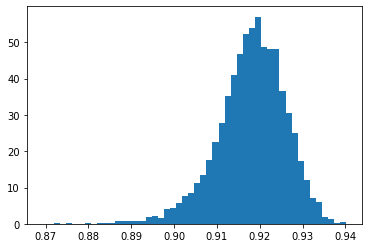

In [9]:
# Plot the (truncated) distribution of growth rates of wealth between age 65 and 66 (=25 + 41)
from matplotlib import pyplot as plt
n, bins, patches = plt.hist(aGro41NoU,50,density=True)

In [10]:
# put your solution here

In [12]:
# put your answer here

In [14]:
# put your answer here

In [16]:
# put your solution here

In [18]:
# put your solution here

# Saving Rates and Lifetime Income Growth

We are interested in how income growth over the lifetime of the agent affects their saving rate and asset ratio $a=A/P$.


Text(0, 0.5, 'Normalized Assets')

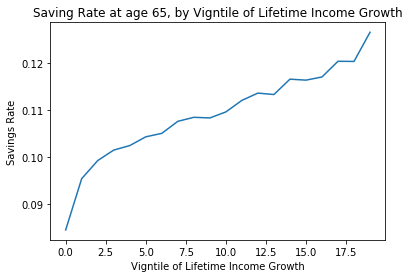

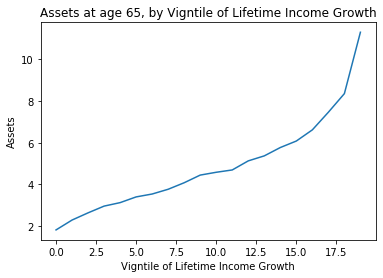

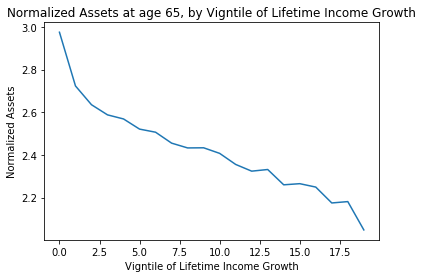

In [20]:
cumulative_income_first_half = np.sum(LifeCyclePop.pLvlNow_hist[0:20,:]*LifeCyclePop.TranShkNow_hist[0:20,:],0)
cumulative_income_second_half = np.sum(LifeCyclePop.pLvlNow_hist[20:40,:]*LifeCyclePop.TranShkNow_hist[20:40,:],0)
lifetime_growth = cumulative_income_second_half/cumulative_income_first_half

t=39
vigntiles = pd.qcut(lifetime_growth,20,labels=False)
savRte = savRteFunc(LifeCyclePop, LifeCyclePop.mNrmNow_hist[t] , t)
savRtgueseByVigtile = np.zeros(20)
assetsByVigtile = np.zeros(20)
assetsNrmByVigtile = np.zeros(20)
savRteByVigtile = np.zeros(20)
for i in range(20):
    savRteByVigtile[i] = np.mean(savRte[vigntiles==i])
    assetsByVigtile[i] = np.mean(LifeCyclePop.aLvlNow_hist[t][vigntiles==i])
    assetsNrmByVigtile[i] = np.mean(LifeCyclePop.aNrmNow_hist[t][vigntiles==i])
plt.plot(np.array(range(20)), savRteByVigtile)
plt.title("Saving Rate at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Savings Rate")

plt.figure()
plt.plot(np.array(range(20)), assetsByVigtile)
plt.title("Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Assets")

plt.figure()
plt.plot(np.array(range(20)), assetsNrmByVigtile)
plt.title("Normalized Assets at age 65, by Vigntile of Lifetime Income Growth")
plt.xlabel("Vigntile of Lifetime Income Growth")
plt.ylabel("Normalized Assets")